<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/04-multilingual-ner/multilingual_named_entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multilingual Named Entity Recognition

In this notebook we will explore how a single Transformer model called XLM-RoBERTa can be fine-tuned to
perform named entity recognition (NER) across several languages. NER is a common NLP task that identifies
entities like people, organizations, or locations in text. These entities can be used for various applications such as
gaining insights from company documents, augmenting the quality of search engines, or simply building a
structured database from a corpus.

##Setup

In [ ]:
%%shell

pip -q install transformers
pip -q install datasets
pip -q install seqeval

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy

from transformers import AutoTokenizer
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoConfig
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorForTokenClassification

from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

from datasets import get_dataset_config_names
from datasets import load_dataset
from datasets import DatasetDict

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from itertools import chain
from collections import defaultdict
from collections import Counter

from IPython.display import HTML, display, set_matplotlib_formats

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

##The Dataset

we will be using a subset of the Cross-lingual TRansfer Evaluation of Multilingual Encoders
(XTREME) benchmark called Wikiann or PAN-X. This dataset consists of Wikipedia articles in many
languages, including the four most commonly spoken languages in Switzerland: German (62.9%), French (22.9%),
Italian (8.4%), and English (5.9%). 

Each article is annotated with LOC (location), PER (person) and ORG
(organization) tags in the “inside-outside-beginning” (IOB2) format, where a B-prefix indicates the beginning of
an entity, and consecutive positions of the same entity are given an I- prefix. An O tag indicates that the token does
not belong to any entity. 

For example, the following sentence



In [5]:
tokens = "Jeff Dean is a computer scientist at Google in California".split()
labels = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]

df = pd.DataFrame(data=[tokens, labels], index=["Tokens", "Tags"])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


To load PAN-X with HuggingFace Datasets we first need to manually download the file AmazonPhotos.zip from
XTREME’s [Amazon Cloud Drive](https://www.amazon.com/clouddrive/share/d3KGCRCIYwhKJF0H3eWA26hjg2ZCRhjpEQtDL70FSBN), and place it in a local directory (data in our example).

For example, to load the
German corpus we use the “de” code as follows:

In [ ]:
load_dataset("xtreme", "PAN-X.de", data_dir="data")

To keep track of each language, let’s create a Python `defaultdict` that stores the language code as the key and
a PAN-X corpus of type `DatasetDict` as the value:

In [ ]:
languages = ["de", "fr", "it", "en"]
fractions = [0.629, 0.229, 0.084, 0.059]

# return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(languages, fractions):
  # load monolingual corpus
  ds = load_dataset("xtreme", f"PAN-X.{lang}")
  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows))))

Here we’ve used the `Dataset.shuffle` function to make sure we don’t accidentally bias our dataset splits,
while `Dataset.select` allows us to downsample each corpus according to the values in fracs. 

Let’s have a
look at how many examples we have per language in the training sets by accessing the `Dataset.num_rows`
attribute:

In [8]:
pd.DataFrame({lang:[panx_ch[lang]["train"].num_rows] for lang in languages}, index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
# Let’s inspect one of the examples in the German corpus
panx_ch["de"]["train"][0]

{'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.']}

In particular, we see that the `ner_tags` column corresponds to the mapping of each entity to an integer. This is a bit cryptic to the human eye,
so let’s create a new column with the familiar `LOC, PER`, and `ORG` tags. 

To do this, the first thing to notice is that
our `Dataset` object has a `features` attribute that specifies the underlying data types associated with each
column:

In [10]:
panx_ch["de"]["train"].features

{'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

The `Sequence` class specifies that the field contains a list of features, which in the case of `ner_tags`
corresponds to a list of ClassLabel `features`. 

Let’s pick out this feature from the training set as follows:

In [11]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [12]:
langs = panx_ch["de"]["train"].features["langs"].feature
langs

Value(dtype='string', id=None)

In [13]:
tokens = panx_ch["de"]["train"].features["tokens"].feature
tokens

Value(dtype='string', id=None)

One handy property of the `ClassLabel` feature is that it has conversion methods to convert from the class name
to an integer and vice versa. 

For example, we can find the integer associated with the `B-PER` tag by using the `ClassLabel.str2int` function as follows:

In [14]:
tags.str2int("B-PER")

1

In [15]:
tags.str2int("I-PER")

2

Similarly, we can map back from an integer to the corresponding class name:

In [16]:
tags.int2str(1)

'B-PER'

In [17]:
tags.int2str(3)

'B-ORG'

Let’s use the `ClassLabel.int2str` function to create a new column in our training set with class names for
each tag. 

We’ll use the `Dataset.map` function to return a dict with the key corresponding to the new column
name and the value as a list of class names:

In [18]:
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [ ]:
panx_de = panx_ch["de"].map(create_tag_names)

In [20]:
panx_de["train"][0]

{'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O'],
 'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.']}

Now that we have our tags in human-readable format, let’s see how the tokens and tags align for the first example in the training set:

In [21]:
de_example = panx_de["train"][0]
df = pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])
df

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


As a sanity check that we don’t have any unusual imbalance in the tags, let’s calculate the frequencies of each
entity across each split:

In [22]:
split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


This looks good - the distribution of the `PER, LOC`, and `ORG` frequencies are roughly the same for each split, so
the validation and test sets should provide a good measure of our `NER` tagger’s ability to generalize.

##Training a Named Entity Recognition Tagger

We know that for text classification, BERT uses the special `[CLS]` token to represent an entire sequence of text.

This representation is then fed through a fully connected
or dense layer to output the distribution of all the discrete label values.

BERT and other encoder
Transformers take a similar approach for NER, except that the representation of every input token is fed into the
same fully-connected layer to output the entity of the token.

For this reason, NER is often framed as a token
classification task.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/04-multilingual-ner/images/1.png?raw=1' width='600'/>

So far, so good, but how should we handle subwords in a token classification task?

For example, the last name `Sparrow` is tokenized by WordPiece into the subwords `Spa` and `##rrow`, so which one (or both)
should be assigned the `I-PER` label?

Although we could have chosen to include the representation from the `##rrow`
subword by assigning it a copy of the `I-LOC` label, this introduces extra complexity when subwords are associated
with a `B-entity` because then we need to copy these tags and this violates the `IOB2` format.

Fortunately, all this intuition from `BERT` carries over to `XLM-R` since the architecture is based on `RoBERTa`,
which is identical to `BERT`! However, there are some slight differences, especially around the choice of tokenizer.

###SentencePiece Tokenization

Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw
text of all 100 languages. The SentencePiece tokenizer is based on a type of subword segmentation called Unigram
and encodes input text as a sequence of Unicode characters. 

To get a feel for how `SentencePiece` compares to `WordPiece`, let’s load the BERT and `XLM-R` tokenizers in the
usual way with `Transformers`:

In [ ]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

By encoding a small sequence of text we can also retrieve the special tokens that each model used during
pretraining:

In [24]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xmlr_tokens = xlmr_tokenizer(text).tokens()

In [25]:
df = pd.DataFrame([bert_tokens, xmlr_tokens], ["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


Here we see that instead of the `[CLS]` and `[SEP]` tokens that BERT uses for sentence classification tasks, XLMR
uses `<s>` and `<\s>` to denote the start and end of a sequence.

Another special feature of SentencePiece is that it
treats raw text as a sequence of Unicode characters, with whitespace given the Unicode symbol `U+2581` or `_`
character. By assigning a special symbol for whitespace, SentencePiece is able to detokenize a sequence without
ambiguities.

We can see that WordPiece has lost the information that there is no whitespace
between `York` and `!`. 

By contrast, SentencePiece preserves the whitespace in the tokenized text so we can
convert back to the raw text without ambiguity:

In [26]:
"".join(xmlr_tokens).replace("▁", " ")

'<s> Jack Sparrow loves New York!</s>'

##Transformers Model Class Anatomy

The Transformers library is organized around dedicated classes for each
architecture and task:

* Sequence classification
* Extractive question answering
* Language modeling
* Named entity recognition
* Summarization
* Translation

and the associated classes are named according to a `ModelNameForTask` convention. Most of the time, we load
these models using the `ModelNameForTask.from_pretrained` function and since the architecture can
usually be guessed from the name alone (e.g. `bert-base-uncased`), Transformers provides a convenient set of AutoClasses to automatically load the relevant configuration, vocabulary, or weights. 

In practice, these
`AutoClasses` are extremely useful because it means that we can switch to a completely different architecture in our
experiments by simply changing the model name!

###XLM-R Model for Token Classification

The separation of bodies and heads allows us to build a custom head for any task and just mount it on top of a
pretrained model!

Let’s go through the exercise of building a a custom token classification head for `XLM-R`. Since
`XLM-R` uses the same model architecture as `RoBERTa`, we will use `RoBERTa` as the base model, but augmented
with settings specific to `XLM-R`.

To get started we need a data structure that will represent our `XLM-R` NER tagger.

As a first guess, we’ll need a
configuration file to initialize the model and a `forward` function to generate the outputs. 

With these
considerations, let’s go ahead and build our `XLM-R` class for token classification:



In [27]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)

    self.num_labels = config.num_labels
    # load model body
    self.roberta = RobertaModel(config, add_pooling_layer=False)
    # setup token classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    # load and initialize weights
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    pass

The only thing left to do is to define what the model should do in a forward pass. 

We define the following behavior
in the `forward` function:

In [28]:
def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    # use model body to get encoder representations
    outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
    # apply classifier to encoder representation
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    # calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    # return model output object
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

The only thing left to do is updating the placeholder function in the model class with our freshly baked functions:

In [29]:
XLMRobertaForTokenClassification.forward = forward

###Loading a Custom Model

Now we are ready to load our token classification model. Here we need to provide some additional information
beyond the model name, including the tags that we will use to label each entity and the mapping of each tag to an
ID and vice versa. 

All of this information can be derived from our `tags` variable, which as a `ClassLabel` object has a names attribute that we can use to derive the mapping:

In [30]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

With this information and the `ClassLabel.num_classes` attribute, we can load the XLM-R configuration for
NER as follows:

In [31]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)

Now, we can load the model weights as usual with the `from_pretrained ` function. 

Note that we did not
implement this ourselves; we get this for free by inheriting from `RobertaPreTrainedModel`:

In [ ]:
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

As a sanity check that we have initialized the tokenizer and model correctly.

Let’s test the predictions on our small
sequence of known entities:

In [33]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

df = pd.DataFrame([xmlr_tokens, input_ids[0].numpy()], ["Tokens", "Inpud IDs"])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Inpud IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


As we can see, the start `<s>` and end `</s>` tokens are given the IDs 0 and 2 respectively. 

For reference we can
find the mappings of the other special characters via the `all_special_ids` and `all_special_tokens`
attributes of `xlmr_tokenizer`:

In [34]:
df = pd.DataFrame([xlmr_tokenizer.all_special_tokens, xlmr_tokenizer.all_special_ids], index=["Special Token", "Special Token ID"])
df

,0,1,2,3,4
Special Token,<s>,</s>,<unk>,<pad>,<mask>
Special Token ID,0,2,3,1,250001


Finally, we need to pass the inputs to the model and extract the predictions by taking the `argmax` to get the most
likely class per token:

In [35]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xmlr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


Here we see that the logits have the shape `[batch_size, num_tokens, num_tags]`, with each token
given a logit among the 7 possible NER tags. 

By enumerating over the sequence, we can quickly see what the
pretrained model predicts:

In [36]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [37]:
predictions[0].cpu().numpy()

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [38]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
df = pd.DataFrame([xmlr_tokens, preds], ["Tokens", "Tags"])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER


Unsurprisingly, our token classification layer with random weights leaves a lot to be desired; let’s fine-tune on
some labeled data to make it better! 

Before doing so, let’s wrap the above steps into a helper function for later use:

In [39]:
def tag_text(text, tags, model, tokenizer):
  # get tokens with special characters
  tokens = tokenizer(text).tokens()
  # encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
  # get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # take argmax to get most likely class per token
  predictions = torch.argmax(outputs, dim=2)
  # convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  df = pd.DataFrame([tokens, preds], ["Tokens", "Tags"])
  
  return df

In [40]:
tag_text(text, tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER


###Tokenizing Texts for NER

Our next step is to tokenize
the whole dataset so that we can pass it to the XLM-R model for fine-tuning.

As we know, Datasets provides a fast way to tokenize a Dataset object with the `Dataset.map` operation. 

To achieve this, recall that
we first need to define a function with the minimal signature.

```python
function(examples: Dict[str, List]) -> Dict[str, List]
```

where examples is equivalent to a slice of a Dataset, e.g. `panx_de['train'][:10]`.

Since the XLM-R
tokenizer returns the input IDs for the model’s inputs, we just need to augment this information with the attention
mask and the label IDs that encode the information about which token is associated with each NER tag.

let’s look at how this works with our single
German example by first collecting the words and tags as ordinary lists:

In [41]:
words, labels = de_example["tokens"], de_example["ner_tags"]

Next we tokenize each word and use the `is_split_words` argument to tell the tokenizer that our input
sequence has already been split into words:

In [42]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
df = pd.DataFrame([tokens], ["Tokens"])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split “Einwohnern” into two subwords "Einwohner” and “n”.
Since we’re following the convention that only “_Einwohner” should be associated with the `_B-LOC` label.

we need a way to mask the subword representations after the first
subword. Fortunately, `tokenized_input` is a class that contains a `word_ids` function that can help us
achieve this:

In [43]:
word_ids = tokenized_input.word_ids()
df = pd.DataFrame([tokens, word_ids], ["Tokens", "Word IDs"])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Let’s set `-100` as the label for these special tokens and the subwords we wish to mask during training:

In [44]:
previous_word_idx = None,
label_ids = []

for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx !=previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

labels = [index2tag[label] if label != -100 else "IGN" for label in label_ids]
df_index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
df = pd.DataFrame([tokens, word_ids, label_ids, labels], index=df_index)
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


>Why did we choose -100 as the ID to mask subword representations? The reason is that in PyTorch the cross entropy loss class
`torch.nn.CrossEntropyLoss` has an attribute called ignore_index whose value is -100. This index is ignored during training
and so we can use it to ignore the tokens associated with consecutive subwords.

So let’s scale this out to the whole dataset
by defining a single function that wraps all the logic:

In [45]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in  word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

Next let’s verify whether our function works as expected on a single training example:

In [ ]:
single_sample = panx_de["train"].select(range(1))
single_sample_encoded = single_sample.map(tokenize_and_align_labels, batched=True)

First, we should be able to decode the training example from the `input_ids`:

In [47]:
print(" ".join(token for token in single_sample[0]["tokens"]))
print(xlmr_tokenizer.decode(single_sample_encoded["input_ids"][0]))

2.000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern .
<s> 2.000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern.</s>


Good, the decoded output from the tokenizer makes sense and we can see the appearance of the special tokens
`<s>` and `</s>` for the start and end of the sentence. 

Next let’s check that the label IDs are implemented correctly
by filtering out the padding label IDs and mapping back from ID to tag:

In [48]:
original_labels = single_sample["ner_tags_str"][0]
reconstructed_labels = [index2tag[idx] for idx in single_sample_encoded["labels"][0] if idx != -100]

df = pd.DataFrame([original_labels, reconstructed_labels], ["Original Labels", "Reconstructed Labels"])
df

,0,1,2,3,4,5,6,7,8,9,10,11
Original Labels,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O
Reconstructed Labels,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


We now have all the ingredients we need to encode each split, so let’s write a function we can iterate over:

In [49]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=["langs", "ner_tags", "tokens"])

By applying this function to a `DatasetDict` object, we get an encoded `Dataset` object per split. 

Let’s use this
to encode our German corpus:

In [ ]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])
panx_de_encoded["train"]

###Performance Measures

Evaluating a NER model is similar to evaluating a text classification model,
and it is common to report results for precision, recall, and F -score. The
only subtlety is that all words of an entity need to be predicted correctly in
order for a prediction to be counted as correct.

Fortunately, there is a nifty
library called [seqeval](https://github.com/chakki-works/seqeval) that is designed for these kinds of tasks.

For example,
given some placeholder NER tags and model predictions, we can compute
the metrics via seqeval’s `classification_report()` function:



In [51]:
y_true = [
   ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
   ["B-PER", "I-PER", "O"]       
]

y_pred = [
   ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
   ["B-PER", "I-PER", "O"]
]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



To integrate these metrics during training, we need a function that can
take the outputs of the model and convert them into the lists that seqeval
expects. 

The following does the trick by ensuring we ignore the label IDs
associated with subsequent subwords:

In [52]:
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

Equipped with a performance metric, we can move on to actually training the
model.

###Fine-Tuning XLM-RoBERTa

Our first strategy
will be to fine-tune our base model on the German subset of PAN-X and then
evaluate its zero-shot cross-lingual performance on French, Italian, and
English. 

As usual, we’ll use the Transformers `Trainer` to handle our training loop, so first we need to define the training attributes using the
`TrainingArguments` class:

In [53]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(output_dir=model_name,
                                  log_level="error",
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  save_steps=1e6, weight_decay=0.01,
                                  disable_tqdm=False, logging_steps=logging_steps)

We also need to tell the Trainer how to compute metrics on the validation set, so here we can use the
`align_predictions` function that we defined earlier to extract the predictions and labels in the format needed
by `seqeval` to calculate the `F1-score`:

In [54]:
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

The final step is to define a data collator so we can pad each input sequence
to the largest sequence length in a batch. 

Transformers provides a
dedicated data collator for token classification that will pad the labels along
with the inputs:

In [55]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

Padding the labels is necessary because, unlike in a text classification task,
the labels are also sequences.

We will train several models, so we’ll avoid
initializing a new model for every Trainer by creating a `model_init()`
method.

In [56]:
def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Let’s pass all this information together with the encoded encoded datasets to the Trainer:

In [57]:
trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

and then run the training loop as follows:

In [58]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.257000,0.151203,0.830240
2,0.130500,0.140132,0.844654
3,0.081700,0.135171,0.859126


TrainOutput(global_step=1575, training_loss=0.15635196265720186, metrics={'train_runtime': 924.447, 'train_samples_per_second': 40.824, 'train_steps_per_second': 1.704, 'total_flos': 862655119377480.0, 'train_loss': 0.15635196265720186, 'epoch': 3.0})

In [59]:
df = pd.DataFrame(trainer.state.log_history)[["epoch", "loss", "eval_loss", "eval_f1"]]
df = df.rename(columns={"epoch": "Epoch", "loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1": "F1"})

df["Epoch"] = df["Epoch"].apply(lambda x: round(x))
df["Training Loss"] = df["Training Loss"].ffill()
df[["Validation Loss", "F1"]] = df[["Validation Loss", "F1"]].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2570,0.151203,0.830240
2,2,0.1305,0.140132,0.844654
4,3,0.0817,0.135171,0.859126


These F1 scores are quite good for a NER model.

To confirm that our model
works as expected, let’s test it on the German translation of our simple
example:

In [60]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


It works! But we should never get too confident about performance based on
a single example. Instead, we should conduct a proper and thorough
investigation of the model’s errors.

##Error Analysis

A thorough error analysis of your model is one of the most important aspects
when training and debugging transformers (and machine learning models in
general). There are several failure modes where it might look like the model
is performing well, while in practice it has some serious flaws.

Examples
where training can fail include:

* We might accidentally mask too many tokens and also mask some of
our labels to get a really promising loss drop.
* The `compute_metrics()` function might have a bug that
overestimates the true performance.
* We might include the zero class or O entity in NER as a normal
class, which will heavily skew the accuracy and F -score since it is
the majority class by a large margin.

When the model performs much worse than expected, looking at the errors
can yield useful insights and reveal bugs that would be hard to spot by just
looking at the code. And even if the model performs well and there are no
bugs in the code, error analysis is still a useful tool to understand the model’s
strengths and weaknesses. 

These are aspects we always need to keep in mind
when we deploy a model in a production environment.

Let’s define a method that we can apply to the validation set:

In [61]:
def forward_pass_with_label(batch):
  # Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # Pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)

  with torch.no_grad():
    # Pass data through model
    output = trainer.model(input_ids, attention_mask)
    # Logit.size: [batch_size, sequence_length, classes]
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  
  # Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
  # Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss": loss, "predicted_label": predicted_label}

We can now apply this function to the whole validation set using `map()` and
load all the data into a DataFrame for further analysis:

In [62]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)

df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7f453f003dd0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/197 [00:00<?, ?ba/s]

The tokens and the labels are still encoded with their IDs, so let’s map the
tokens and labels back to strings to make it easier to read the results. For the
padding tokens with label –100 we assign a special label, IGN, so we can
filter them later.

In [63]:
index2tag[-100] = "IGN"

df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])

df["loss"] = df.apply(lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)

df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.017579574, 0.0, 0.034057412, 0.0253554...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


Let’s have a look at the tokens individually by unpacking these
lists. The `pandas.Series.explode()` function allows us to do exactly that
in one line by creating a row for each element in the original rows list. 

Since
all the lists in one row have the same length, we can do this in parallel for all
columns. We also drop the padding tokens we named IGN, since their loss is
zero anyway. 

Finally, we cast the losses, which are still `numpy.Array`
objects, to standard floats:

In [64]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.03,I-ORG,▁(
0,16104,1,I-ORG,0.03,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.42,B-ORG,▁Luz
1,10,1,I-ORG,0.41,I-ORG,▁a


With the data in this shape, we can now group it by the input tokens and
aggregate the losses for each token with the count, mean, and sum. 

Finally,
we sort the aggregated data by the sum of the losses and see which tokens
have accumulated the most loss in the validation set:

In [65]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
             .agg(["count", "mean", "sum"])
             .droplevel(level=0, axis=1)  # Get rid of multi-level columns
             .sort_values(by="sum", ascending=False)
             .reset_index()
             .round(2)
             .head(10)
             .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.04,0.09,0.13,0.14,0.61,0.07,0.29,0.27,0.02,0.43
sum,216.01,128.83,125.28,115.53,99.01,85.33,70.63,67.33,63.25,53.27


We can observe several patterns in this list:
* The whitespace token has the highest total loss, which is not
surprising since it is also the most common token in the list.
However, its mean loss is much lower than the other tokens in the
list. This means that the model doesn’t struggle to classify it.
* Words like “in”, “von”, “der”, and “und” appear relatively
frequently. They often appear together with named entities and are
sometimes part of them, which explains why the model might mix
them up.
* Parentheses, slashes, and capital letters at the beginning of words
are rarer but have a relatively high average loss. We will investigate
them further.
* At the end of list we see some subwords that appear rarely but have a very high average loss. 

For example
`_West` shows that these tokens appear in almost any class, and thus pose a classification challenge to the
model:


In [66]:
df_tokens.query("input_tokens == '_West'")["labels"].value_counts()

Series([], Name: labels, dtype: int64)

We can also group the label IDs and look at the losses for each class:

In [67]:
(
    df_tokens.groupby("labels")[["loss"]]
             .agg(["count", "mean", "sum"])
             .droplevel(level=0, axis=1)  # Get rid of multi-level columns
             .sort_values(by="mean", ascending=False)
             .reset_index()
             .round(2)
             .head(10)
             .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.62,0.59,0.47,0.3,0.28,0.2,0.03
sum,1660.35,857.7,1782.52,956.45,807.79,820.3,1416.65


We see that `B-ORG` has the highest average loss, which means that determining
the beginning of an organization poses a challenge to our model.

We can break this down further by plotting the confusion matrix of the token
classification, where we see that the beginning of an organization is often
confused with the subsequent `I-ORG` token:



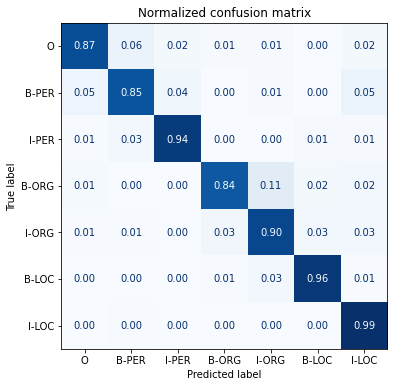

In [68]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

From the plot, we can see that our model tends to confuse the `B-ORG` and `I-ORG`
entities the most. Otherwise, it is quite good at classifying the remaining
entities, which is clear by the near diagonal nature of the confusion matrix.

Now that we’ve examined the errors at the token level, let’s move on and
look at sequences with high losses. For this calculation, we’ll revisit our
“unexploded” `DataFrame` and calculate the total loss by summing over the
loss per token.

To do this, let’s first write a function that helps us display the
token sequences with the labels and the losses:

In [69]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
    yield df_tmp

In [70]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,B-ORG,O,O,O,O,O,B-ORG,O
losses,0.00,0.00,4.80,0.00,0.00,0.00,10.59,10.10,8.06,6.44,5.99,0.00,6.53,7.34,0.00,8.34,8.17,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.82,0.00,0.00,4.19,8.43,8.70,6.22,0.00,8.33,8.76,7.84,6.46,5.59,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,5.89,5.16,5.93,0.00,5.84,0.00,5.71,0.00,5.19,5.52,5.85,5.52,5.16,5.18,0.00


It is apparent that something is wrong with the labels of these samples; for
example, the United Nations and the Central African Republic are each
labeled as a person! At the same time, “8. Juli” in the first example is
labeled as an organization. It turns out the annotations for the PAN-X dataset
were generated through an automated process.

Another thing we noticed earlier was that parentheses and slashes had a
relatively high loss. 

Let’s look at a few examples of sequences with an
opening parenthesis:

In [71]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.02,0.00,0.03,0.03,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


In general we would not include the parentheses and their contents as part of
the named entity, but this seems to be the way the automatic extraction
annotated the documents.

With a relatively simple analysis, we’ve identified some weaknesses in both
our model and the dataset. In a real use case we would iterate on this step,
cleaning up the dataset, retraining the model, and analyzing the new errors
until we were satisfied with the performance.

##Evaluating Cross-Lingual Transfer

Now that we have fine-tuned XLM-R on German, we can evaluate its ability
to transfer to other languages via the `predict()` method of the Trainer.

Since we plan to evaluate multiple languages, let’s create a simple function
that does this for us:

In [72]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

To keep track of our performance per language, our function also returns the micro-averaged `F1-score`. 

Let’s use
this function to examine the performance on the test set and keep track of our scores in a `dict`:

In [73]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.868


These are pretty good results for a NER task. Our metrics are in the ballpark
of 85%, and we can see that the model seems to struggle the most on the ORG
entities, probably because these are the least common in the training data and
many organization names are rare in XLM-R’s vocabulary. 

How about the
other languages? To warm up, let’s see how our model fine-tuned on German
fares on French:

In [74]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


Not bad! Although the name and organization are the same in both languages,
the model did manage to correctly label the French translation of
“Kalifornien”.

Next, let’s quantify how well our German model fares on the
whole French test set by writing a simple function that encodes a dataset and
generates the classification report on it:

In [75]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])

In [ ]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)

In [77]:
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.706


Although German and French are grouped as Indo-European languages, they technically belong to different language
families: Germanic and Romance, respectively.

Next, let’s evaluate the performance on Italian. Since Italian is also a
Romance language, we expect to get a similar result as we found on French:

In [ ]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)

In [79]:
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.663


Indeed, our expectations are borne out by the `F-scores`. 

Finally, let’s
examine the performance on English, which belongs to the Germanic
language family:

In [ ]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)

In [81]:
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.592


Surprisingly, our model fares worst on English, even though we might
intuitively expect German to be more similar to English than French. 

Having
fine-tuned on German and performed zero-shot transfer to French and
English, let’s next examine when it makes sense to fine-tune directly on the
target language.

###Zero-Shot Transfer

Fine-tuning XLM-R on the German corpus yields an
F-score of around `85%`, and without any additional training the model is
able to achieve modest performance on the other languages in our corpus.

We will explore this question for the French corpus by finetuning
XLM-R on training sets of increasing size. By tracking the performance this way, we can determine at which point zero-shot crosslingual
transfer is superior, which in practice can be useful for guiding
decisions about whether to collect more labeled data.

For simplicity, we’ll keep the same hyperparameters from the fine-tuning run
on the German corpus, except that we’ll tweak the `logging_steps` argument
of Training Ar guments to account for the changing training set sizes.

In [96]:
batch_size = 16

def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]

  training_args.logging_steps = len(train_ds) // batch_size

  trainer = Trainer(model_init=model_init,
                    args=training_args,
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                    train_dataset=train_ds,
                    eval_dataset=valid_ds,
                    tokenizer=xlmr_tokenizer)
  trainer.train()

  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message="Training completed!")
  
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

As we did with fine-tuning on the German corpus, we also need to encode
the French corpus into input IDs, attention masks, and label IDs:

In [ ]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Next let’s check that our function works by running it on a small training set
of 250 examples:

In [90]:
training_args.push_to_hub = False

metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17/cache-0ae0fac2809daec1.arrow
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.820000,1.319333,0.014571
2,1.307600,1.175348,0.174646
3,1.113400,1.083382,0.184793


,num_samples,f1_score
0,250,0.180111


We can see that with only 250 examples, fine-tuning on French
underperforms the zero-shot transfer from German by a large margin.

Let’s now increase our training set sizes to 500, 1,000, 2,000, and 4,000 examples to get an idea of how the performance increases:

In [98]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17/cache-0ae0fac2809daec1.arrow


RuntimeError: ignored

We can compare how fine-tuning on French samples compares to zero-shot
cross-lingual transfer from German by plotting the F-scores on the test set as a function of increasing training set size:

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

From the plot we can see that zero-shot transfer remains competitive until
about 750 training examples, after which fine-tuning on French reaches a
similar level of performance to what we obtained when fine-tuning on
German.

Nevertheless, this result is not to be sniffed at!

In our experience,
getting domain experts to label even hundreds of documents can be costly,
especially for NER, where the labeling process is fine-grained and timeconsuming.

There is one final technique we can try to evaluate multilingual learning:
fine-tuning on multiple languages at once!

###Fine-Tuning on Multiple Languages